In [0]:
 !pip install -U -q PyDrive ## you will have install for every colab session

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import os
import numpy as np
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pickle as pkl
import h5py
import numpy as np
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, TensorBoard,Callback
from keras.models import Model
from keras.layers import merge, Flatten, Dense, Input, Dropout, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.layers.noise import GaussianNoise
np.random.seed(4)
K.set_image_dim_ordering('th')

In [0]:
json_import = drive.CreateFile({'id':'11_s04x0bjQLEpAU-mdbNIqTzMMUWUSHh'})
json_import.GetContentFile('train.npy')
train = np.load('train.npy')
json_import = drive.CreateFile({'id':'1VDVO_aChOxUvQs_DRzYGn3plwgMrkrLR'})
json_import.GetContentFile('train_mask.npy')
train_mask = np.load('train_mask.npy')

In [5]:
train.shape,train_mask.shape

((1279, 3, 128, 128), (1279, 1, 128, 128))

In [0]:
json_import = drive.CreateFile({'id':'14R6ZLGIg6VVH363dj4tAo7c3lBQW6Rnh'})
json_import.GetContentFile('val.npy')
val = np.load('val.npy')
json_import = drive.CreateFile({'id':'1Qt6XwBGK3WszQHvN71XkZqGNFSsIkD4T'})
json_import.GetContentFile('val_mask.npy')
val_mask = np.load('val_mask.npy')

In [7]:
val.shape,val_mask.shape

((320, 3, 128, 128), (320, 1, 128, 128))

In [0]:
json_import = drive.CreateFile({'id':'1JGej9IwAWk6N6y6_d4AzPiJgfXUYE4Gb'})
json_import.GetContentFile('test.npy')
test = np.load('test.npy')
json_import = drive.CreateFile({'id':'1BM3PGKXkyoTgq8MfVGgIvDBzTWSobGsJ'})
json_import.GetContentFile('test_mask.npy')
test_mask = np.load('test_mask.npy')

In [9]:
test.shape,test_mask.shape

((401, 3, 128, 128), (401, 1, 128, 128))

In [0]:
seed = 1
height, width = 128, 128
nb_epoch = 20
model_name = "model1"

do_train = True
do_predict = True 
model = 'unet'
batch_size = 4
loss_param = 'BCE'
optimizer_param = 'adam'
monitor_metric = 'val_acc'
fc_size = 2048
mean_type = 'imagenet'
rescale_mask = True
use_hsv = False
dataset='isic' 
initial_epoch = 0 

metrics = ['acc']
if use_hsv:
    n_channels = 6
    print "Using HSV"
else:
    n_channels = 3

remove_mean_imagenet=False
remove_mean_samplewise=False
remove_mean_dataset=False
if mean_type == 'imagenet':
    remove_mean_imagenet = True;
elif mean_type == 'sample':
    remove_mean_samplewise = True
elif mean_type == 'dataset':
    remove_mean_dataset = True
    train_mean = np.array([[[ 180.71656799]],[[ 151.13494873]],[[ 139.89967346]]]);
    train_std = np.array([[[1]],[[1]],[[ 1]]]); # not using std
else:
    raise Exception("Wrong mean type")
    
loss_options = {'BCE': 'binary_crossentropy', 'mse':'mean_squared_error'}
optimizer_options = {'adam': Adam(lr=1e-5),
                     'sgd': SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)}

loss = loss_options[loss_param]
optimizer = optimizer_options[optimizer_param]
model_filename = "weights/{}.h5".format(model_name)

In [11]:
mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [12]:
mkdir results

mkdir: cannot create directory ‘results’: File exists


In [13]:
ls

datalab/  segmentation_train_log.csv  test.npy        train.npy     val.npy
results/  test_mask.npy               train_mask.npy  val_mask.npy  weights/


In [0]:
def myGenerator(train_generator, train_mask_generator, 
                remove_mean_imagenet=True, rescale_mask=True, use_hsv=False):
    while True:
        train_gen = next(train_generator)
        train_mask = next(train_mask_generator)
                
        if False: # use True to show images
            mask_true_show = np.where(train_mask>=0.5, 1, 0)
            mask_true_show = mask_true_show * 255
            mask_true_show = mask_true_show.astype(np.uint8)
            for i in range(train_gen.shape[0]):
                mask = train_mask[i].reshape((width,height))
                img=train_gen[i]
                img = img[0:3]
                img = img.astype(np.uint8)
                img = img.transpose(1,2,0)
                f, ax = plt.subplots(1, 2)
                ax[0].imshow(img); ax[0].axis("off");
                ax[1].imshow(mask, cmap='Greys_r'); ax[1].axis("off"); plt.show()
        yield (train_gen, train_mask)


In [0]:
def seg_model(img_rows, img_cols, loss , optimizer, metrics, fc_size = 8192, channels = 3):
    filter_size = 5
    filter_size_2 = 11
    dropout_a = 0.5
    dropout_b = 0.5
    dropout_c = 0.5
    gaussian_noise_std = 0.025

    inputs = Input((channels, img_rows, img_cols))
    input_with_noise = GaussianNoise(gaussian_noise_std)(inputs)

    conv1 = Conv2D(32, (filter_size, filter_size), activation='relu', padding='same')(input_with_noise)
    conv1 = Conv2D(32, (filter_size, filter_size), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, (filter_size, filter_size), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1)
    pool1 = GaussianNoise(gaussian_noise_std)(pool1)

    conv2 = Conv2D(64, (filter_size, filter_size), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (filter_size, filter_size), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, (filter_size, filter_size), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2)
    pool2 = GaussianNoise(gaussian_noise_std)(pool2)

    conv3 = Conv2D(128, (filter_size, filter_size), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (filter_size, filter_size), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, (filter_size, filter_size), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3)
    pool3 = Dropout(dropout_a)(pool3)

    fc = Flatten()(pool3)
    fc = Dense(fc_size, activation='relu')(fc)
    fc = Dropout(dropout_b)(fc)

    n = img_rows/2/2/2
    fc = Dense(128*n*n, activation='relu')(fc)
    fc = GaussianNoise(gaussian_noise_std)(fc)
    fc = Reshape((128,n,n))(fc)

    up1 = merge([UpSampling2D(size=(2, 2))(fc), conv3], mode='concat', concat_axis=1)
    up1 = Dropout(dropout_c)(up1)

    conv4 = Conv2D(128, (filter_size_2, filter_size_2), activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, (filter_size, filter_size), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(64, (filter_size, filter_size), activation='relu', padding='same')(conv4)

    up2 = merge([UpSampling2D(size=(2, 2))(conv4), conv2], mode='concat', concat_axis=1)
    up2 = Dropout(dropout_c)(up2)

    conv5 = Conv2D(64, (filter_size_2, filter_size_2), activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, (filter_size, filter_size), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(32, (filter_size, filter_size), activation='relu', padding='same')(conv5)

    up3 = merge([UpSampling2D(size=(2, 2))(conv5), conv1], mode='concat', concat_axis=1)
    up3 = Dropout(dropout_c)(up3)

    conv6 = Conv2D(32, (filter_size_2, filter_size_2), activation='relu', padding='same')(up3)
    conv6 = Conv2D(32, (filter_size, filter_size), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(32, (filter_size, filter_size), activation='relu', padding='same')(conv6)

    conv7 = Conv2D(1, 1, 1, activation='sigmoid')(conv6)

    model = Model(input=inputs, output=conv7)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [16]:
 model = seg_model(height,width, loss=loss, optimizer = optimizer, metrics = metrics, fc_size = fc_size, channels=n_channels)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Update

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 3, 128, 128)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 2432        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 25632       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
model_checkpoint = ModelCheckpoint(model_filename, monitor=monitor_metric, save_best_only=True, verbose=1)
data_gen_args = dict(featurewise_center=False, 
                            samplewise_center=remove_mean_samplewise, 
                            featurewise_std_normalization=False, 
                            samplewise_std_normalization=False, 
                            zca_whitening=False, 
                            rotation_range=270, 
                            width_shift_range=0.1, 
                            height_shift_range=0.1, 
                            horizontal_flip=False, 
                            vertical_flip=False, 
                            zoom_range=0.2,
                            channel_shift_range=0,
                            fill_mode='reflect')
data_gen_mask_args = dict(data_gen_args.items() + {'fill_mode':'nearest','samplewise_center':False}.items())

In [0]:
train_datagen = ImageDataGenerator(**data_gen_args)
train_mask_datagen = ImageDataGenerator(**data_gen_mask_args)
train_generator = train_datagen.flow(train, batch_size=batch_size, seed=seed)
train_mask_generator = train_mask_datagen.flow(train_mask, batch_size=batch_size, seed=seed)
train_generator_f = myGenerator(train_generator, train_mask_generator, 
                                   remove_mean_imagenet=remove_mean_imagenet,
                                    rescale_mask=rescale_mask, use_hsv=use_hsv)

In [0]:
early_stopper = EarlyStopping(min_delta=0.001, patience=5)
csv_logger = CSVLogger('segmentation_train_log.csv')

In [0]:
n_samples = train.shape[0]

In [0]:
history = model.fit_generator(
            train_generator_f,
            samples_per_epoch=n_samples,
            nb_epoch=nb_epoch, validation_data=(val,val_mask), 
            callbacks=[model_checkpoint,early_stopper,csv_logger], initial_epoch=initial_epoch)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., initial_epoch=0, validation_data=(array([[[..., steps_per_epoch=1279, epochs=20, callbacks=[<keras.ca...)`
  """


Epoch 1/20
1278/1279 [============================>.] - ETA: 0s - loss: 0.2683 - acc: 0.8944

1279/1279 [==============================] - 645s 504ms/step - loss: 0.2682 - acc: 0.8944 - val_loss: 0.1558 - val_acc: 0.9445

Epoch 00001: val_acc improved from -inf to 0.94454, saving model to weights/model1.h5
Epoch 2/20
 254/1279 [====>.........................] - ETA: 8:23 - loss: 0.1783 - acc: 0.9293

1279/1279 [==============================] - 639s 499ms/step - loss: 0.1625 - acc: 0.9338 - val_loss: 0.1490 - val_acc: 0.9505

Epoch 00002: val_acc improved from 0.94454 to 0.95048, saving model to weights/model1.h5
Epoch 3/20
  46/1279 [>.............................] - ETA: 10:04 - loss: 0.1255 - acc: 0.9453

1278/1279 [============================>.] - ETA: 0s - loss: 0.1387 - acc: 0.9404

1279/1279 [==============================] - 639s 499ms/step - loss: 0.1386 - acc: 0.9404 - val_loss: 0.1546 - val_acc: 0.9468

Epoch 00003: val_acc did not improve
Epoch 4/20
 291/1279 [=====>........................] - ETA: 8:04 - loss: 0.1304 - acc: 0.9429

1279/1279 [==============================] - 639s 499ms/step - loss: 0.1279 - acc: 0.9437 - val_loss: 0.1527 - val_acc: 0.9457

Epoch 00004: val_acc did not improve
Epoch 5/20
  68/1279 [>.............................] - ETA: 9:53 - loss: 0.1175 - acc: 0.9467

1278/1279 [============================>.] - ETA: 0s - loss: 0.1210 - acc: 0.9453

1279/1279 [==============================] - 638s 499ms/step - loss: 0.1209 - acc: 0.9453 - val_loss: 0.1116 - val_acc: 0.9559

Epoch 00005: val_acc improved from 0.95048 to 0.95591, saving model to weights/model1.h5
Epoch 6/20
 252/1279 [====>.........................] - ETA: 8:23 - loss: 0.1147 - acc: 0.9472

1279/1279 [==============================] - 638s 499ms/step - loss: 0.1136 - acc: 0.9479 - val_loss: 0.1180 - val_acc: 0.9543

Epoch 00006: val_acc did not improve
Epoch 7/20
  56/1279 [>.............................] - ETA: 9:58 - loss: 0.1286 - acc: 0.9417

1278/1279 [============================>.] - ETA: 0s - loss: 0.1104 - acc: 0.9488

1279/1279 [==============================] - 638s 499ms/step - loss: 0.1105 - acc: 0.9487 - val_loss: 0.1167 - val_acc: 0.9560

Epoch 00007: val_acc improved from 0.95591 to 0.95597, saving model to weights/model1.h5
Epoch 8/20
 252/1279 [====>.........................] - ETA: 8:23 - loss: 0.1163 - acc: 0.9474

1279/1279 [==============================] - 638s 499ms/step - loss: 0.1091 - acc: 0.9489 - val_loss: 0.1280 - val_acc: 0.9535

Epoch 00008: val_acc did not improve
Epoch 9/20
  56/1279 [>.............................] - ETA: 9:57 - loss: 0.1028 - acc: 0.9511

1278/1279 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9508

1279/1279 [==============================] - 637s 498ms/step - loss: 0.1037 - acc: 0.9508 - val_loss: 0.1065 - val_acc: 0.9601

Epoch 00009: val_acc improved from 0.95597 to 0.96009, saving model to weights/model1.h5
Epoch 10/20
 251/1279 [====>.........................] - ETA: 8:24 - loss: 0.0998 - acc: 0.9526

1279/1279 [==============================] - 638s 499ms/step - loss: 0.0980 - acc: 0.9528 - val_loss: 0.1031 - val_acc: 0.9587

Epoch 00010: val_acc did not improve
Epoch 11/20
  55/1279 [>.............................] - ETA: 9:58 - loss: 0.1084 - acc: 0.9528

1278/1279 [============================>.] - ETA: 0s - loss: 0.0981 - acc: 0.9529

1279/1279 [==============================] - 638s 499ms/step - loss: 0.0980 - acc: 0.9530 - val_loss: 0.0947 - val_acc: 0.9612

Epoch 00011: val_acc improved from 0.96009 to 0.96116, saving model to weights/model1.h5
Epoch 12/20
 251/1279 [====>.........................] - ETA: 8:24 - loss: 0.0897 - acc: 0.9561

1279/1279 [==============================] - 638s 499ms/step - loss: 0.0945 - acc: 0.9542 - val_loss: 0.1093 - val_acc: 0.9584

Epoch 00012: val_acc did not improve
Epoch 13/20
  55/1279 [>.............................] - ETA: 9:59 - loss: 0.1079 - acc: 0.9504 

1278/1279 [============================>.] - ETA: 0s - loss: 0.0940 - acc: 0.9543

1279/1279 [==============================] - 637s 498ms/step - loss: 0.0940 - acc: 0.9543 - val_loss: 0.0987 - val_acc: 0.9607

Epoch 00013: val_acc did not improve
Epoch 14/20
 290/1279 [=====>........................] - ETA: 8:04 - loss: 0.0918 - acc: 0.9552

1279/1279 [==============================] - 637s 498ms/step - loss: 0.0907 - acc: 0.9555 - val_loss: 0.0960 - val_acc: 0.9621

Epoch 00014: val_acc improved from 0.96116 to 0.96215, saving model to weights/model1.h5
Epoch 15/20
  55/1279 [>.............................] - ETA: 9:58 - loss: 0.0894 - acc: 0.9579

1278/1279 [============================>.] - ETA: 0s - loss: 0.0916 - acc: 0.9552

1279/1279 [==============================] - 637s 498ms/step - loss: 0.0917 - acc: 0.9551 - val_loss: 0.0915 - val_acc: 0.9633

Epoch 00015: val_acc improved from 0.96215 to 0.96326, saving model to weights/model1.h5
Epoch 16/20
 251/1279 [====>.........................] - ETA: 8:23 - loss: 0.0937 - acc: 0.9545

1279/1279 [==============================] - 637s 498ms/step - loss: 0.0896 - acc: 0.9556 - val_loss: 0.1159 - val_acc: 0.9551

Epoch 00016: val_acc did not improve
Epoch 17/20
  55/1279 [>.............................] - ETA: 9:57 - loss: 0.0954 - acc: 0.9530

 776/1279 [=================>............] - ETA: 4:06 - loss: 0.0874 - acc: 0.9565

In [0]:
K.clear_session()

In [35]:
cd ..

/content


In [0]:
file = drive.CreateFile({'parents':[{u'id': '1o_Sj1gEpFkLjnMuc6ouG6i7ppcyS2SgB'}]}) 
file.SetContentFile("segmentation_train_log.csv")
file.Upload()

In [0]:
model.load_weights('weights/model1.h5')

In [41]:
acc = model.evaluate(test,test_mask)
print("Accuracy:%.4f"%acc[1])

401/401 [==============================] - 5s 12ms/step
Accuracy:0.9607


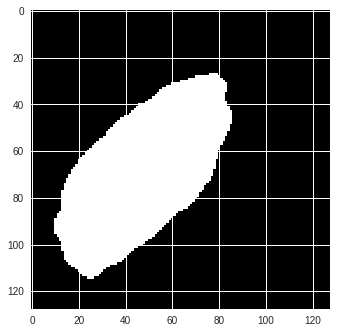

In [57]:
gt = test_mask[3].reshape((128,128))
plt.imshow(gt, cmap = "gray")

In [0]:
testing_image = test[3].reshape((1,3,128,128))

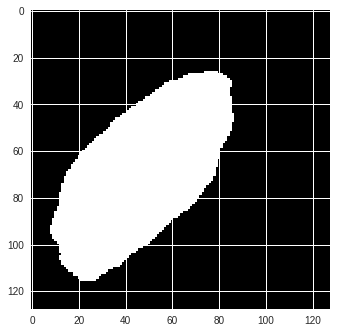

In [59]:
prediction = model.predict(testing_image)
prediction = prediction.reshape((128,128))
sample = prediction > 0.5
plt.imshow(sample, cmap = "gray")